In [ ]:
# getting data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# some universal imports

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings('ignore')

# Part A : Sentiment Analysis

In this part, we train an LSTM (Neural Network) model using the train data provided (train_new2. and tweets_labelled_09042020_16072020.csv - renamed to labelled.csv). The data is first processed using nltk library and then fed into the RNN-based model as part of training. The model will be used in Part B to predict the sentiment scores for the stocks-tweets that will scraped

a) Data handling/preprocessing

In [ ]:
%%capture

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data/sent_anal/train_new2.csv')
df1 = df1.rename(columns={'comment_text': 'Text', 'toxic': 'Sentiment'})
df1['Sentiment'] = df1['Sentiment'].apply(lambda x: 1.0-x) 
df1.dropna(inplace=True)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/data/sent_anal/labelled.csv', sep=';')
df2 = df2[['text', 'sentiment']]
df2 = df2.rename(columns={'text': 'Text', 'sentiment': 'Sentiment'})
df2.dropna(inplace=True)
df2.loc[df2['Sentiment'] == 'positive', 'Sentiment'] = 1.0
df2.loc[df2['Sentiment'] == 'negative', 'Sentiment'] = 0.0
df2.loc[df2['Sentiment'] == 'neutral', 'Sentiment'] = .5

In [ ]:
# combine the two train dataframes 
df_train_sentiment = pd.concat([df1, df2], axis=0)
df_train_sentiment.tail(n=10)

,Text,Sentiment
1290,$GOOG #patent 20200127702 Data over Power Line...,0.5
1291,Mon Jun 22nd\nToday's BEST performing sector a...,1.0
1292,Q3 2020 EPS Estimates for Ball Co. $BLL Increa...,1.0
1293,RT @MightySoldiers: #DayTrading #livestream\nL...,0.5
1294,"$UNH - UnitedHealth beats EPS consensus, reite...",0.5
1295,#stocks back from the recovery room: https://t...,1.0
1296,RT @MacroCharts: Breadth – expanding last week...,1.0
1297,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,0.5
1298,$AAPL $QQQ Top may now be in. https://t.co/iNK...,1.0
1299,GLG Partners LP short position in HILTON FOOD ...,0.0


In [ ]:
# function to do data processing: takes in the name of the column to do preprocessing and the dataframe

def data_processor(column_name, df):

        # Convert all text to lowercase
        df[column_name] = df[column_name].str.lower()

        # Remove punctuation and digits
        df[column_name] = df[column_name].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation+string.digits)))

        # Tokenize the text
        df[column_name] = df[column_name].apply(lambda x: nltk.word_tokenize(x))

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in stop_words])

        # Lemmatize the text
        lemmatizer = WordNetLemmatizer()
        df[column_name] = df[column_name].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

        # Join the tokens back into a string
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x))

        # Remove any remaining non-alphabetic characters
        df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x))

        # Drop any empty rows
        df.dropna(inplace=True)

        return df

In [ ]:
df_train_sentiment = data_processor('Text', df_train_sentiment)
df_train_sentiment.tail(n=10)

,Text,Sentiment
1290,goog patent data power line design tech ip res...,0.5
1291,mon jun nd today best performing sector close ...,1.0
1292,q eps estimate ball co bll increased analyst h...,1.0
1293,rt mightysoldiers daytrading livestream live b...,0.5
1294,unh unitedhealth beat eps consensus reiterates...,0.5
1295,stock back recovery room httpstcohvvlwwodu fai...,1.0
1296,rt macrocharts breadth expanding last week di...,1.0
1297,rt mawsonresource rompasrajapalot big new camp...,0.5
1298,aapl qqq top may httpstcoinkwbtxus,1.0
1299,glg partner lp short position hilton food grou...,0.0


b) Modeling

In [ ]:
# training LSTM model using preprocessed data for sentiment analysis

# imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from keras.utils import to_categorical

In [ ]:
# a function to do some preprocessing just before fitting

def data_preprocessor(input_dim, max_len, features_col, attribute_col, df):

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

        # Convert the text to sequences
        tokenizer = Tokenizer(num_words=input_dim)
        tokenizer.fit_on_texts(X_train)
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_test_seq = tokenizer.texts_to_sequences(X_test)

        # Pad the sequences
        X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
        X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

        return X_train_pad, y_train, X_test_pad, y_test


In [ ]:
X_train_pad, y_train, X_test_pad, y_test = data_preprocessor(10000, 200, 'Text', 'Sentiment', df_train_sentiment)
X_train_pad, y_train = X_train_pad.astype('float32'), y_train.astype('float32')
X_test_pad, y_test = X_test_pad.astype('float32'), y_test.astype('float32')

In [ ]:
# The LSTM Model architecture

sentiment_class_model = Sequential()
sentiment_class_model.add(Embedding(input_dim=10000, output_dim=100, input_length=200))
sentiment_class_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
sentiment_class_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
sentiment_class_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 128                                                                   # <---------------------------------------------------------
epochs = 3                                                                         # <--------------------------------------------------------
history = sentiment_class_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test))

Epoch 1/3
71/71 [==============================] - 165s 2s/step - loss: 0.4005 - accuracy: 0.8436 - val_loss: 0.3002 - val_accuracy: 0.8447
Epoch 2/3
71/71 [==============================] - 136s 2s/step - loss: 0.2094 - accuracy: 0.8921 - val_loss: 0.2572 - val_accuracy: 0.8681
Epoch 3/3
71/71 [==============================] - 135s 2s/step - loss: 0.1229 - accuracy: 0.9309 - val_loss: 0.2888 - val_accuracy: 0.8752


# Part B : Predictive Analysis

## Part b (i) Data Handling/Preprocessing

In this part, we:

1.   scrape stocks prices data
2.   load stocks tweets data

The tweets data here is matched to the relevant stocks data. Each tweet is then matched against the stock in which it mentions. The tweets, after matching to the stocks mentioned, are also matched to the specific day to which they align with the stock they are influencing. 

This strategy aims to not just blindly assume the sentiment effects of a tweet on a stock price, but really match the sentiment down to the exact day it affected the price. By doing so, we aim to create a really accurate, really on-point basis onto which we base our tweets-stock relation argument. 

This strategy also aims to improve the prediction capability (accuracy scores) of the Model that will be used to predict stock movement based on tweets sentiment.

More importantly, the open prices for the stocks can be used to gauge the effect of the sentiment as it (the opening price) gives a foundation on to which the price started and where a basis can be formed. 
For instance: if the sentiment metrics (i.e sentiment mean) for a specific day were generally negative, then one can look at the highest, lowest and closing prices and conclude on where the tweets sentiment led the the stock prices to during that day.
This thought-strategy can be used to create additional metrics based on open, high, low and close prices, which can then be used to create more favorable predictors on how sentiment can be used to predict price movement



In [ ]:
# Define the start and end dates of the desired range
start_date = pd.Timestamp('2020-06-01', tz='UTC')                                 # <-----------------------------------------------
end_date = pd.Timestamp('2020-06-26', tz='UTC')                                   # <-----------------------------------------------

a) Stocks prices data

In [ ]:
%%capture
! pip3 install yfinance

import yfinance as yf

In [ ]:
%%capture

# stocks data

# define the tickers and date range
tickers = ['AAPL'] #, 'GOOG', 'MSFT', 'AMZN', 'TSLA']                             # <-----------------------------------------------

df_stock_prices = pd.DataFrame()

# loop through each ticker and get the historical data
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    # add a column for the ticker symbol
    data['Ticker'] = ticker
    # append the data to the results dataframe
    df_stock_prices = df_stock_prices.append(data)

df_stock_prices_aapl = df_stock_prices.reset_index()[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

b) Tweets data

In [ ]:
# tweets data

df_tweets = pd.read_csv('/content/drive/MyDrive/data/sent_anal/unlabelled.csv', sep=';')
df_tweets = df_tweets[['created_at','full_text']]
df_tweets = df_tweets.rename(columns={'created_at':'Date', 'full_text': 'Tweet'})

df_tweets['Date'] = pd.to_datetime(df_tweets['Date'], utc=True)

# Use boolean indexing to select the rows within the range
df_tweets = df_tweets[(df_tweets['Date'] >= start_date) & (df_tweets['Date'] <= end_date)]
df_tweets['Tweet'] = df_tweets['Tweet'].str.lower()
df_tweets = df_tweets.reset_index(drop=True)
df_tweets['Date'] = df_tweets['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
# A utility function to reduce the number of tweets in each day to only 50 tweets/day

def reduce_tweets_df(df):
    checked = {}
    idxs = []
    for idx, row in df.iterrows():
      date = str(row['Date'])
      tweet = row['Tweet']
      if date not in checked.keys():
            checked[date] = 1
            idxs.append(idx)
      else:
            c = checked[date]
            if c < 21:                                                            # <-----------------------------------------------                             
                checked[date] = c+1
                idxs.append(idx)

    df = df.iloc[idxs]
    return df

In [ ]:
# Function to perform the sentiment prediction usin previously trained LSTM model

# function to preprocess input text just before prediction
def preprocess_text(text):
  
    # Tokenize the text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([text])
    text_sequence = tokenizer.texts_to_sequences([text])[0]

    # Pad the sequence to a fixed length: using length used in training model
    max_length = 200
    padded_sequence = pad_sequences([text_sequence], maxlen=max_length)

    return padded_sequence

# function to predict sentiment
def predict_sentiment(text):

    # Preprocess the input text
    preprocessed_text = preprocess_text(text)

    # Make a prediction with the LSTM model
    prediction = sentiment_class_model.predict(preprocessed_text)[0][0]

    return prediction

In [ ]:
%%capture

# selecting tweets that mention apple stocks only
keywords = ['apple', 'appl']
mask = df_tweets['Tweet'].str.contains('|'.join(keywords))
df_tweets_aapl = df_tweets[mask]
df_tweets_aapl = df_tweets_aapl.reset_index(drop=True)

# reducing the size of the tweets dataframe
df_tweets_aapl = reduce_tweets_df(df_tweets_aapl)

# processing tweets data using previously defined function
df_tweets_aapl = data_processor('Tweet', df_tweets_aapl)

# predict_sentiment function to each row in the 'Tweet' column
df_tweets_aapl['Sentiment'] = df_tweets_aapl['Tweet'].apply(predict_sentiment)

In [ ]:
# Group the DataFrame by date and compute the toxic mean of each date
df_sentiment_mean_aapl = df_tweets_aapl.groupby('Date')['Sentiment'].mean()
df_sentiment_mean_aapl = pd.DataFrame(df_sentiment_mean_aapl).reset_index()
df_sentiment_mean_aapl['Date'] = pd.to_datetime(df_sentiment_mean_aapl['Date'])

c) Merging Stocks and Tweets sentiment data

In [ ]:
'''
Handling Stocks and Tweets, and their respective dates. We match the day's mean sentiment with the respective day's prices
'''
df_sentiment_mean_aapl = pd.merge(df_stock_prices_aapl, df_sentiment_mean_aapl, on='Date', how='outer')
df_sentiment_mean_aapl = df_sentiment_mean_aapl.sort_values('Date').fillna(method='ffill').reset_index(drop=True)

c) Feature engineering

Creating additional features from the merged dataset. The additional features will be used by the model for the prediction of whethera stock will go up/down the next day

In [ ]:
# computing metrics from Open, High, Low, Close prices

df_1 = df_sentiment_mean_aapl
df_1['S.H'] = df_1['High']-df_1['Open']
df_1['S.L'] = df_1['Open']-df_1['Low']
df_1['S.C'] = df_1['Close']-df_1['Open']
df_1['S.A.C'] = df_1['Adj Close']-df_1['Open']
df_1['Prev Delta A.C'] = df_1['Adj Close']-df_1['Adj Close'].shift(1)
df_1['Next Delta A.C'] = df_1['Adj Close'].shift(-1)-df_1['Adj Close']
df_1.fillna(0, inplace=True)

d) Defining Buy/Sell labels

In [ ]:
# define the conditions and the values to assign to column C
df = df_1[['Sentiment','S.H','S.L','S.C','S.A.C', 'Prev Delta A.C', 'Next Delta A.C']]

conditions = [(df['Next Delta A.C'] > 0), (df['Next Delta A.C'] == 0.0000000), (df['Next Delta A.C'] < 0)]
values = ['B', 'n', 'S']

# assign 'n' for all other values of column A
df['Best Action'] = np.select(conditions, values)
df = df.drop('Next Delta A.C', axis=1)

In [ ]:
# create a scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# normalize the dataframe
df_new = pd.DataFrame()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['S.H','S.L','S.C','S.A.C','Prev Delta A.C']]), columns=['S.H','S.L','S.C','S.A.C','Prev Delta A.C'])
df_scaled['Best Action'] = df['Best Action']
df_new['Sentiment'] = df['Sentiment']

df_train = pd.concat([df_new, df_scaled], axis=1)
df_train.head(n=10)

,Sentiment,S.H,S.L,S.C,S.A.C,Prev Delta A.C,Best Action
0,0.671270,-0.341904,-0.938729,0.386384,0.412740,0.233345,B
1,0.975561,-0.630861,-0.752004,0.266826,0.290533,0.341822,B
2,0.850229,-0.804839,-0.673228,0.098179,0.118589,0.362943,S
3,0.804189,-0.851742,-0.490879,-0.102137,-0.079058,0.029490,B
4,0.839571,0.232982,-1.000000,0.707048,0.722201,0.901702,n
5,0.842819,0.232982,-1.000000,0.707048,0.722201,0.233345,n
6,0.759219,0.232982,-1.000000,0.707048,0.722201,0.233345,B
7,0.771304,-0.531012,-0.590080,0.315915,0.326320,0.376044,B
8,0.793458,1.000000,-0.998540,1.000000,1.000000,1.000000,B
9,0.933287,0.001514,-0.753464,0.452892,0.438061,0.877681,S


In [ ]:
# split data into features and labels
X = df_train.iloc[:, :-1].values
y = df_train.iloc[:, -1:].values

## Part b (ii) Data Analysis

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns

Stocks Analysis

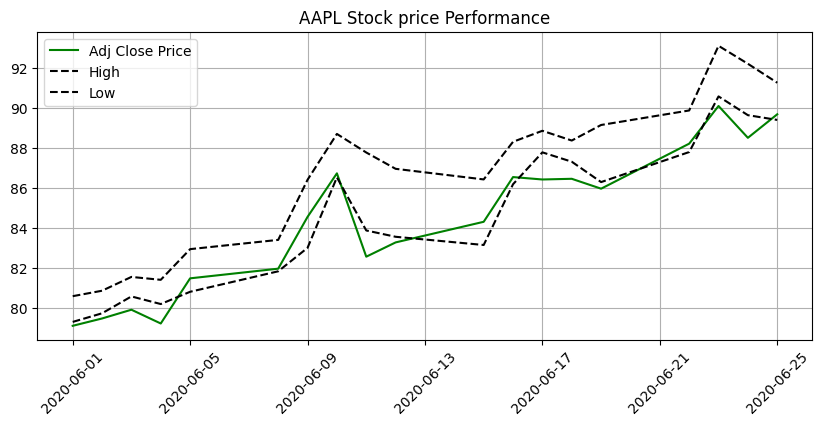

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df_stock_prices_aapl['Date'], df_stock_prices_aapl['Adj Close'], c='green', label='Adj Close Price')
plt.plot(df_stock_prices_aapl['Date'], df_stock_prices_aapl['High'], c='black', linestyle='--', label='High')
plt.plot(df_stock_prices_aapl['Date'], df_stock_prices_aapl['Low'], c='black', linestyle='--', label='Low')

plt.title('AAPL Stock price Performance')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

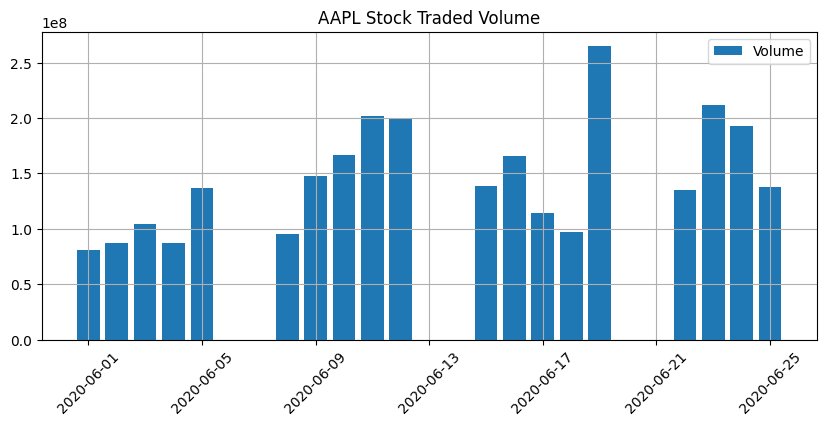

In [ ]:
plt.figure(figsize=(10,4))

plt.bar(df_stock_prices_aapl['Date'], df_stock_prices_aapl['Volume'], label='Volume')

plt.title('AAPL Stock Traded Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

Tweets Analysis

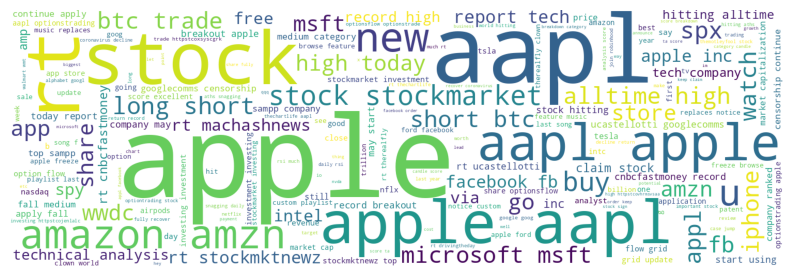

In [ ]:
# create a string containing all text data
all_text = ' '.join(df_tweets_aapl['Tweet'])

# create a word cloud object
wordcloud = WordCloud(width=1500, height=500, background_color='white').generate(all_text)

# plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Stocks vs Tweets Analysis

In [ ]:
adj_close_prices = df_sentiment_mean_aapl['Adj Close'].apply(lambda x: (x - df_sentiment_mean_aapl['Adj Close'].min()) / (df_sentiment_mean_aapl['Adj Close'].max() - df_sentiment_mean_aapl['Adj Close'].min()))
volume = df_stock_prices_aapl['Volume'].apply(lambda x: (x - df_stock_prices_aapl['Volume'].min()) / (df_stock_prices_aapl['Volume'].max() - df_stock_prices_aapl['Volume'].min()))


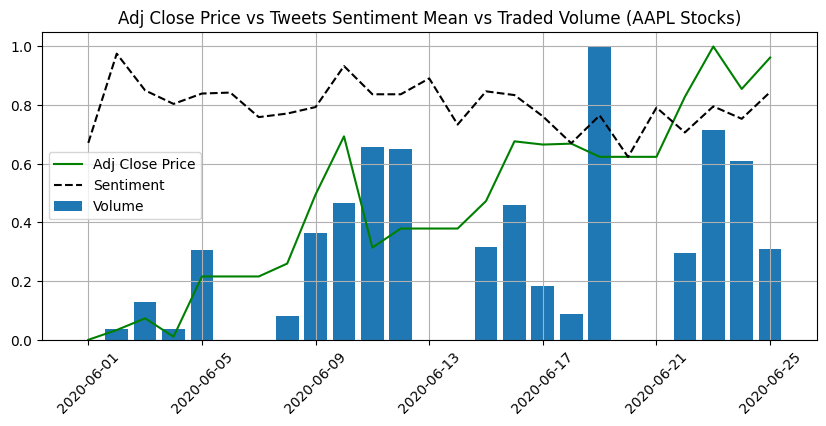

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df_sentiment_mean_aapl['Date'], adj_close_prices, c='green', label='Adj Close Price')
plt.plot(df_sentiment_mean_aapl['Date'], df_sentiment_mean_aapl['Sentiment'], c='black', linestyle='--', label='Sentiment')
plt.bar(df_stock_prices_aapl['Date'], volume, label='Volume')

plt.title('Adj Close Price vs Tweets Sentiment Mean vs Traded Volume (AAPL Stocks)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

Extracted Features Analysis

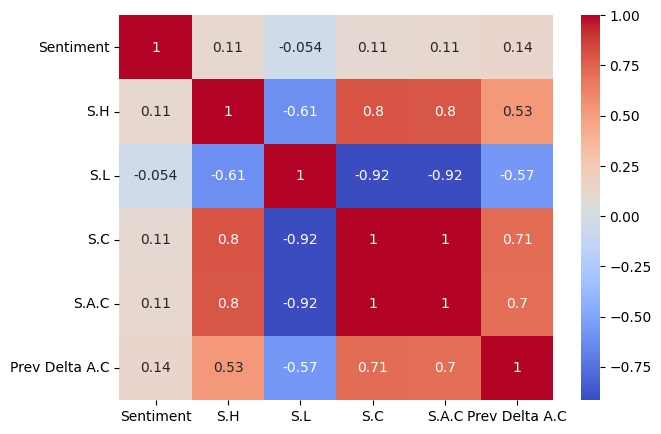

In [ ]:
# compute the correlation matrix
corr_matrix = df_train.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Part b (iii) Modeling and Prediction

This part implements the strategies that were defined in Part B. The data needed for the project has been processed towards the strategies targeted by the project. The predicting models are initialized, trained using data from the previous part, and, evaluated in this part.

a) Modeling

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm

In [ ]:
%%capture
# Modeling

'''
The metrics obtained above are then used as features and attributes for our prediction models. 
We first define a new models, train it on the data, and, then use it to predict stock price movement

'''

# a) MLP Model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, alpha=0.0001, solver='adam', verbose=0,  random_state=42, tol=0.0001)
mlp_model.fit(X, y)

# b) SVM Model
svm_model = svm.SVC()
svm_model.fit(X,y)

# c) SGD classifier Model
sgd_model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
sgd_model.fit(X,y)

# d) Decision Tree classifier Model
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X,y)

# e) Gradient Boosting classifier Model
gradboosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gradboosting_model.fit(X, y)

# f) Logistic Regression model
logreg_model = LogisticRegression(random_state=1)
logreg_model.fit(X,y)

# g) Random forest classifier
randforest_model = RandomForestClassifier(n_estimators=50, random_state=1)
randforest_model.fit(X,y)

# h) Gaussian NB classifier
gaussian_model = GaussianNB()
gaussian_model.fit(X,y)


c) Performance evaluation

Performance evaluation tests the ability of the Model to predict the swing of the stock price based on the project's derived metrics. The metrics are heavily dependent on the Sentiment statistics supplied by a tweet analysis of the tweets mentioning the stock in question. Accompanying the derived sentiments are: the stock's swing highs and the swing lows, and, the stock's change in adjusted close prices.

NOTE: The model has been trained on one stock, and will be tested on a different stock entirely. In this case, the model has been trained using AAPL stocks, and its prediction power is tested on MSFT stocks. This aims to prove the strength of the model in predictive analysis.

In [ ]:
%%capture

# stocks data

# define the tickers and date range
tickers = ['MSFT'] #, 'AMZN', 'TSLA']                                             # <-----------------------------------------------

df_stock_prices_test = pd.DataFrame()

# loop through each ticker and get the historical data
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    # add a column for the ticker symbol
    data['Ticker'] = ticker
    # append the data to the results dataframe
    df_stock_prices_test = df_stock_prices_test.append(data)

df_stock_prices_test = df_stock_prices_test.reset_index()[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

In [ ]:
%%capture

# tweets data

# selecting tweets that mention apple stocks only
keywords = ['microsft', 'msft']                                                     # <------------------------------------------------
mask = df_tweets['Tweet'].str.contains('|'.join(keywords))
df_tweets_test = df_tweets[mask]
df_tweets_test = df_tweets_test.reset_index(drop=True)

# reducing the size of the tweets dataframe
df_tweets_test = reduce_tweets_df(df_tweets_test)

# processing tweets data using previously defined function
df_tweets_test = data_processor('Tweet', df_tweets_test)

# predict_sentiment function to each row in the 'Tweet' column
df_tweets_test['Sentiment'] = df_tweets_test['Tweet'].apply(predict_sentiment)

In [ ]:
# Group the DataFrame by date and compute the toxic mean of each date
df_sentiment_mean_test = df_tweets_test.groupby('Date')['Sentiment'].mean()
df_sentiment_mean_test = pd.DataFrame(df_sentiment_mean_test).reset_index()
df_sentiment_mean_test['Date'] = pd.to_datetime(df_sentiment_mean_test['Date'])

In [ ]:
'''
Handling Stocks and Tweets, and their respective dates. We match the day's mean sentiment with the respective day's prices
'''
df_stocks_sentiment_mean_test = pd.merge(df_stock_prices_test, df_sentiment_mean_test, on='Date', how='outer')
df_stocks_sentiment_mean_test = df_stocks_sentiment_mean_test.sort_values('Date').fillna(method='ffill').reset_index(drop=True)

In [ ]:
# computing metrics from Open, High, Low, Close prices

df_1 = df_stocks_sentiment_mean_test
df_1['S.H'] = df_1['High']-df_1['Open']
df_1['S.L'] = df_1['Open']-df_1['Low']
df_1['S.C'] = df_1['Close']-df_1['Open']
df_1['S.A.C'] = df_1['Adj Close']-df_1['Open']
df_1['Prev Delta A.C'] = df_1['Adj Close']-df_1['Adj Close'].shift(1)
df_1['Next Delta A.C'] = df_1['Adj Close'].shift(-1)-df_1['Adj Close']
df_1.fillna(0, inplace=True)

In [ ]:
df = df_1[['Sentiment','S.H','S.L','S.C','S.A.C', 'Prev Delta A.C', 'Next Delta A.C']]

# define the conditions and the values to assign to column C
conditions = [(df['Next Delta A.C'] > 0), (df['Next Delta A.C'] == 0), (df['Next Delta A.C'] < 0)]
values = ['B', 'n', 'S']

# assign 'n' for all other values of column A
df['Best Action'] = np.select(conditions, values)
df = df.drop('Next Delta A.C', axis=1)

In [ ]:
# normalize the dataframe
df_new = pd.DataFrame()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['S.H','S.L','S.C','S.A.C','Prev Delta A.C']]), columns=['S.H','S.L','S.C','S.A.C','Prev Delta A.C'])
df_scaled['Best Action'] = df['Best Action']
df_new['Sentiment'] = df['Sentiment']

df = pd.concat([df_new, df_scaled], axis=1)

# split data into features and labels
X_test = df.iloc[:, :-1].values
y_true = df['Best Action']

In [ ]:
# Utility function to compute accuracy between y_pred and y_test

def compute_accuracy(y_pred):
  if len(y_pred) == len(y_true):
    accurate = 0
    l = len(y_pred)
    for prediction, actual in zip(y_pred, y_true):
      if prediction == actual:
        accurate += 1
    print(f'Number of days Model is Accurate: {accurate} \n\nTotal Days Tested: {l} \n\nAccuracy: {accurate/l} \n')

In [ ]:
# MLP Model

y_pred = mlp_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 15 

Total Days Tested: 25 

Accuracy: 0.6 



In [ ]:
# Logistic Regeression Model

y_pred = logreg_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 15 

Total Days Tested: 25 

Accuracy: 0.6 



In [ ]:
# SVM Model

y_pred = svm_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 14 

Total Days Tested: 25 

Accuracy: 0.56 



In [ ]:
# Random Forest Model

y_pred = randforest_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 14 

Total Days Tested: 25 

Accuracy: 0.56 



In [ ]:
# SGD Model

y_pred = sgd_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 14 

Total Days Tested: 25 

Accuracy: 0.56 



In [ ]:
# Gaussian Model

y_pred = gaussian_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 12 

Total Days Tested: 25 

Accuracy: 0.48 



In [ ]:
# Gradientboosting Model

y_pred = gradboosting_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 10 

Total Days Tested: 25 

Accuracy: 0.4 



In [ ]:
# Decison Tree Model

y_pred = dt_model.predict(X_test)
compute_accuracy(y_pred)

Number of days Model is Accurate: 7 

Total Days Tested: 25 

Accuracy: 0.28 



the end